In [1]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 3D electrostatics example

In [1]:
import sys
import logging, os
import numpy as np
# To import pyface.py is just for setting "Qt" sip API version to 2 before matplotlib sets it to default v1 
# that is incompatible with "pyside" in package "mayavi". wwc
import pyface.qt    
import matplotlib.pyplot as plt
from multiprocessing import Pool    # parallel computation.

sys.path.append('../../')   # add path of package "bem" to search list. wwc
sys.path.append('../../../electrode/')   # add path of package "electrode" to search list. wwc

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

In [2]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    # hucul-wwc_180802_0d1-10-2d5 # hucul-west_20180710_0d1-10-2d5_wwc
    prefix = "hucul-wwc_180813_0d1-0d1-5"
suffix = ""

In [3]:
### scale to natural units (ion height)
scale = 200e-6    # 40 um: from ion to electrode.
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    # s_nta is binary stl file after processing, will explain in next cell. wwc
    s_nta = stl.read_stl(open("%s.stl" % prefix, "rb"))
    print "Import stl:", os.path.abspath("./"+prefix+".stl"),"\n"
    # print s_nta
    # At first you don't know the coded numbers of electorde colors, just randomly specify rename argument 
    # like this, and stl.stl_to_mesh() will drop the numbers for you in the output. wwc 
    # stl_to_mesh() only assigns names and does scaling, it does nothing to stl mesh.  wwc
    print "Electrode colors (numbers):\n"
    # scale=scale/1e-6    1e-6: use micron as unit. so we only scale dimensionless scale/1e-6.
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,rename={1:"DC1"}))    

Import stl: /home/wwc/bem_git/bem/examples/3DTrap/hucul-wwc_180813_0d1-0d1-5.stl 

Electrode colors (numbers):

dropping 2581
dropping 23887
dropping 1530
dropping 8456
dropping 1882
dropping 28165
dropping 24
dropping 0
dropping 1633
dropping 30653
dropping 30850
dropping 24603
dropping 24063


In [4]:
print len(s_nta), type(s_nta), "\n"    # s_nta is a length 3 tuple. wwc
# normal, triangle, attribute wwc
# normal direction of each triangle, three vetice of triangles, coded color numbers wwc
# print s_nta[0], s_nta[1], s_nta[2], "\n"
print "Triangles:",len(s_nta[0]),"\n", "Colors:",len(s_nta[2]),"\n"    # This isn't right.  wwc

# Use the color numbers to give each electrode a name after the first try. wwc"
# Won't print any non-zero number now. wwc
# 1e-6 is in the unit of um.
mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,
    rename={0:"DC1",30653:"DC2",30850:"DC3",24603:"DC4",1633:"DC5", 
            1530:"DC6",28165:"DC7",1882:"DC8",8456:"DC9",23887:"DC10",
           24:"RF1",24063:"RF2"}))    
    #rename={24:"RF"}))
    #rename={1633:"DC1"}))
    
    # 0:Black, 24:Red, 24311:Default, 1633:Dark Green, 30653:White, 28165:Cyran, 1882:Yello, 1530:Orange  wwc
    # 30850:blue wall, 24063:pink, 830/2581:default gold, 24603:meganta, 23887:violet,8456:Dark Gray

3 <type 'tuple'> 

Triangles: 2672 
Colors: 2672 

dropping 2581
7 planes in electrode DC10
Normals vectors are:
[[-8.47737149e-16 -4.99983281e-01 -8.66035044e-01]
 [ 2.06010476e-01 -8.47458422e-01  4.89258528e-01]
 [ 3.07936207e-16 -6.77893817e-01 -7.35159814e-01]
 [-4.45956945e-01  7.75148511e-01 -4.47512239e-01]
 [ 2.72330177e-15 -8.66035044e-01  4.99983281e-01]
 [ 9.84981262e-16  2.97683328e-01  9.54664648e-01]
 [-1.94896008e-16  4.99983281e-01  8.66035044e-01]]
7 planes in electrode DC6
Normals vectors are:
[[ 4.83951427e-16  4.99983281e-01  8.66035044e-01]
 [ 4.45956945e-01  7.75148511e-01 -4.47512239e-01]
 [-4.17889978e-16 -6.77893817e-01 -7.35159814e-01]
 [-2.06010476e-01 -8.47458422e-01  4.89258528e-01]
 [ 2.84207585e-16 -8.66035044e-01  4.99983281e-01]
 [ 3.67308108e-16  2.97683328e-01  9.54664648e-01]
 [ 1.46171999e-16 -4.99983281e-01 -8.66035044e-01]]
7 planes in electrode DC9
Normals vectors are:
[[ 4.45956945e-01 -7.75148511e-01  4.47512239e-01]
 [-1.99531912e-16 -6.77893

Output vtk: /home/wwc/bem_git/bem/examples/3DTrap/hucul-wwc_180813_0d1-0d1-5.vtk


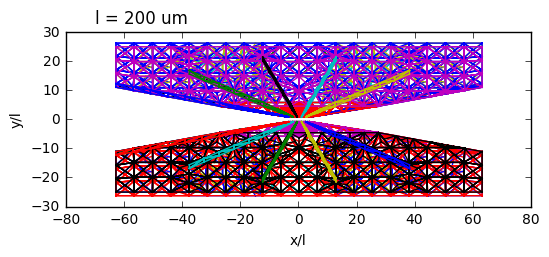

In [9]:
# set .1 max area within 3
# This cell draws triangle meshes. wwc
# areas_from_constraints specifies a region with finer mesh. wwc
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 0.]),    # Finer mesh inside sphere. wwc
           radius=5, inside=0.2, outside=10))    # "inside", "outside" assign different mesh densities. wwc
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix+suffix)
print "Output vtk:",os.path.abspath("./"+prefix+suffix+".vtk")    # path of output  wwc

# Plot the mesh. Finer mesh at center is caused by above "Sphere". wwc
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
mesh.plot(ax)

ax.set_xlabel("x/l",fontsize=10)
ax.set_ylabel("y/l",fontsize=10)
ax.text(-70,33,"l = %d um"%(scale/1e-6),fontsize=12)
fig.set_dpi(100)

In [6]:
# Define a function for computation. wwc
def run_job(args):
    # job is Configuration instance.  wwc
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min
    # angle 25deg
    job.adapt_mesh(triangles=4e2, opts="q15Q")
    job.adapt_mesh(triangles=1e3, opts="q15Q")
    # solve for charges
    # The general path is, 1. Iteratively solve charge distribution until it's consistent with 
    # one electrode at 1V and others at 0V. wwc
    job.solve_singularities(num_lev=3)
    # get potentials and fields
    # 2. Potentials on grid points are calculated by Configuration.simulate, 
    # based on charge distributions previously gotten. wwc
    # (For RF the method is different from DC? num_lev=1 specifies its fastlap mode. See README.rst.) wwc
    RF_field = (job.name=="RF1") or (job.name=="RF2")  # wwc
    result = job.simulate(grid, field=RF_field, num_lev=1)    # For "RF", field=True so it computes the field. wwc
    result.to_vtk(prefix)
    print "finished job %s" % job.name
    return job.collect_charges()

In [6]:
# grid to evalute potential and fields at
n, s = 2*60, 0.05  
Lx, Ly, Lz = 2, 2, 2        # um
sx, sy, sz = s, s, s                        # pay attention to "s/2. not "s/2", we are in python 2. wwc
# n is the grid point number, s is step length. So to fix size on i direction you need to fix ni*si. wwc
nx, ny, nz = [2*(int(L/2.0/s)+1) for L in (Lx, Ly, Lz)]
print "Size(um)", Lx, Ly, Lz
print "Step", sx, sy, sz
print "Shape (grid point numbers)", nx, ny, nz
# center: (nx, ny ,nz)/2 shifts to center (so n must be even). shape: the computation region. wwc
grid = Grid(center=(0, 0, 0), step=(sx, sy, sz), shape=(nx, ny, nz))

Size(um) 2 2 2
Step 0.05 0.05 0.05
Shape (grid point numbers) 42 42 42


In [8]:
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*","RF.*"))    # select() is to pick one electrode each time. wwc
# run the different electrodes on the parallel pool
#pmap = Pool().map # parallel map
pmap = map # serial map
pmap(run_job, ((job, grid, prefix+suffix) for job in jobs))
# run_job will cast a word after finishing each electrode. wwc

finished job DC10
finished job DC6
finished job DC9
finished job DC8
finished job DC7
finished job RF1
finished job DC1
finished job DC5
finished job DC2
finished job DC3
finished job DC4
finished job RF2


[array([ 8.78364812e+01, -9.75018952e-02, -7.16463784e+01, -2.96650313e-01,
        -1.12580642e-01, -7.96845232e+00, -1.08871058e+00, -5.70040482e-02,
        -1.15602794e-01, -4.78998920e-02, -3.76872322e-02, -3.54535185e+00]),
 array([-9.75884841e-02,  8.78247572e+01, -1.12196742e-01, -2.95500681e-01,
        -7.16312068e+01, -7.97263946e+00, -5.70429077e-02, -1.08925819e+00,
        -3.76680506e-02, -4.77462184e-02, -1.15162571e-01, -3.54574920e+00]),
 array([-7.13572225e+01, -1.13473406e-01,  1.05688011e+02, -2.65433812e+01,
        -2.34668483e-01, -4.14462657e+00, -1.15723629e-01, -3.78826904e-02,
        -4.47690019e-02, -2.92492596e-02, -2.28562550e-02, -1.62728113e+00]),
 array([-2.90799190e-01, -2.94119399e-01, -2.65368239e+01,  5.96668934e+01,
        -2.65483205e+01, -3.28692252e+00, -4.71537928e-02, -4.70954089e-02,
        -2.89741545e-02, -3.47588762e-02, -2.90631440e-02, -1.32573385e+00]),
 array([-1.12468662e-01, -7.14837802e+01, -2.34423117e-01, -2.65354685e+01,
    

yz plane, DC potential
p max 1.01207 
p min -0.012432


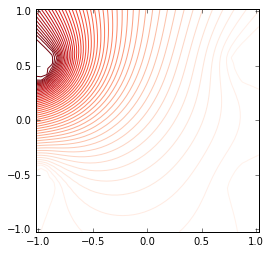

In [40]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix+suffix, "DC3")
praw = result.potential
x = grid.to_mgrid()[:,p.shape[0]/2]    # ~ :,p.shape[0]/2,:,:  at nx/2. wwc
p = praw[praw.shape[0]/2]
print "yz plane,","DC potential"
maxp,minp = np.amax(praw),np.amin(praw)    # Want to know if an electrode is set 1V. wwc
print "p max", maxp,"\n","p min", minp
fig, ax = plt.subplots()
ax.set_aspect("equal")
# yz plane should use x[1], x[2]. wwc
ax.contour(x[1], x[2], p, levels=np.linspace(minp, maxp, 50), cmap=plt.cm.Reds)    # 2e-2

yz plane, DC potential
p max 1.00208 
p min -0.00116714


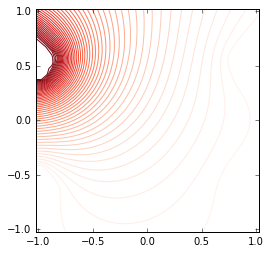

In [11]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix+suffix, "DC4")
p = result.potential
x = grid.to_mgrid()[:,p.shape[0]/2]    # ~ :,p.shape[0]/2,:,:  at nx/2. wwc
p = p[p.shape[0]/2-20]
print "yz plane,","DC potential"
maxp,minp = np.amax(p),np.amin(p)    # Want to know if an electrode is set 1V. wwc
print "p max", maxp,"\n","p min", minp
fig, ax = plt.subplots()
ax.set_aspect("equal")
# yz plane should use x[1], x[2]. wwc
ax.contour(x[1], x[2], p, levels=np.linspace(minp, maxp, 50), cmap=plt.cm.Reds)    # 2e-2

yz plane, RF pseudo
p max 5.66374 
p min 1.6569e-07


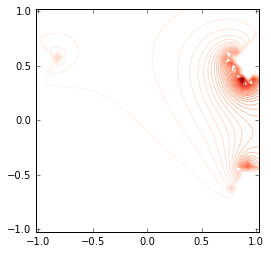

In [10]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix+suffix, "RF1")
p = result.pseudo_potential    # pseudo_potential
x = grid.to_mgrid()[:, p.shape[0]/2]    # p.shape[0]/2 is at the middle of x. wwc
p = p[p.shape[0]/2]    # get the slice of yz plane at x = p.shape[0]/2, the middle plane. wwc
print "yz plane, RF pseudo"
maxp,minp = np.amax(p),np.amin(p)
print "p max", maxp,"\n","p min", minp
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(minp, maxp, 50), cmap=plt.cm.Reds)

xy plane, DC potential
p max 1.01207 
p min -0.00344212


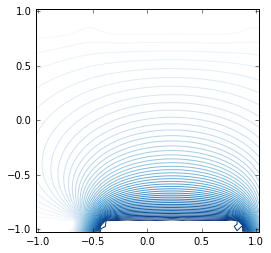

In [11]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix+suffix, "DC3")
praw = result.potential
coord = grid.to_mgrid()    # coord is a special coordinate structure which is prepared for plt.contour(). wwc
x = coord[:,:,:,praw.shape[2]/2]    # ?
p = praw[:,:,praw.shape[2]/2+8]    # praw.shape[2]/2 gets the middle xy plane along z. wwc 
print "xy plane, DC potential"
maxp,minp = np.amax(p),np.amin(p)
print "p max", maxp,"\n","p min", minp
fig, ax = plt.subplots()
ax.set_aspect("equal")
# xy plane should use x[0] and x[1]. levels=[start, end, number] of potential lines. wwc
ax.contour(x[0], x[1], p, levels=np.linspace(minp, maxp, 50), cmap=plt.cm.Blues) 

xy plane, RF pseudo
p max 1.0041 
p min -0.00214104


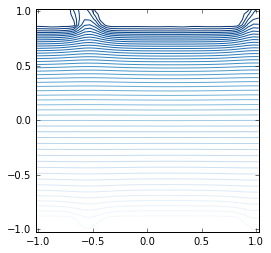

In [12]:
# isocontour plot of the RF pseudopotential radially wwc
result = Result.from_vtk(prefix+suffix, "RF1")
p = result.potential
coord = grid.to_mgrid()
x = coord[:,:,:,p.shape[2]/2]
p = p[:,:,p.shape[2]/2+8]
print "xy plane, RF pseudo"
maxp,minp = np.amax(p),np.amin(p)
print "p max", maxp,"\n","p min", minp
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(minp, maxp, 50), cmap=plt.cm.Blues)

xz plane, DC potential
p max 1.00559 
p min -0.00559656


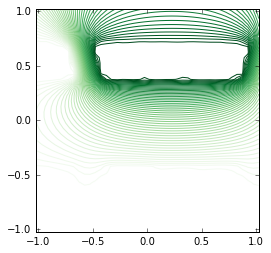

In [91]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix+suffix, "DC3")
praw = result.potential
coord = grid.to_mgrid()    # coord is a special coordinate structure which is prepared for plt.contour(). wwc
x = coord[:,:,praw.shape[1]/2]    # ?
p = praw[:,praw.shape[1]/2-20]    # praw.shape[2]/2 gets the middle xy plane along z. wwc 
print "xz plane, DC potential"
maxp,minp = np.amax(p),np.amin(p)
print "p max", maxp,"\n","p min", minp
fig, ax = plt.subplots()
ax.set_aspect("equal")
# xy plane should use x[0] and x[1]. levels=[start, end, number] of potential lines. wwc
ax.contour(x[0], x[2], p, levels=np.linspace(minp, maxp, 50), cmap=plt.cm.Greens) 

yz plane, superposition
p max 2058.9989696293997 
p min -0.0011804769


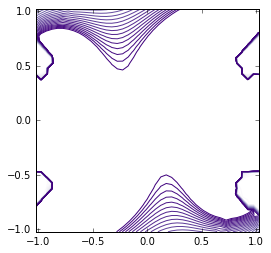

In [74]:
# isocontour plot of the DC potential
rfnames = " RF1 RF2".split()
dcnames = "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10".split()
rfpots = np.array([300,300],dtype=np.double)
dcpots = np.array([10,0,0,0,10,10,0,0,0,10],dtype=np.double)

total = 0
for name,pot in zip(rfnames,rfpots):
    result = Result.from_vtk(prefix+suffix, name)
    total += pot*result.pseudo_potential
for name,pot in zip(dcnames,dcpots):
    result = Result.from_vtk(prefix+suffix, name)
    total += pot*result.potential

x = grid.to_mgrid()[:,total.shape[0]/2]
p = total[total.shape[0]/2]
print "yz plane, superposition"
maxp,minp = np.amax(p),np.amin(p)
print "p max", maxp,"\n","p min", minp
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(minp, maxp/30, 50), cmap=plt.cm.Purples)

xy plane, superposition
p max 346.2405214 
p min 73.0618774


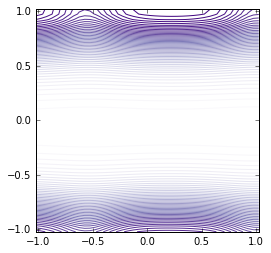

In [75]:
# isocontour plot of the DC potential
total = 0
for name,pot in zip(rfnames,rfpots):
    result = Result.from_vtk(prefix+suffix, name)
    total += pot*result.pseudo_potential
for name,pot in zip(dcnames,dcpots):
    result = Result.from_vtk(prefix+suffix, name)
    total += pot*result.potential

x = grid.to_mgrid()[:,:,:,total.shape[2]/2]
p = total[:,:,total.shape[2]/2]
print "xy plane, superposition"
maxp,minp = np.amax(p),np.amin(p)
print "p max", maxp,"\n","p min", minp
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(minp, maxp, 50), cmap=plt.cm.Purples)

In [110]:
result = Result.from_vtk(prefix+suffix, "DC1")
p = result.potential    # potential
x = grid.to_mgrid()[:, p.shape[0]/2]
print x
p.shape

[[[ 0.025  0.025  0.025 ...  0.025  0.025  0.025]
  [ 0.025  0.025  0.025 ...  0.025  0.025  0.025]
  [ 0.025  0.025  0.025 ...  0.025  0.025  0.025]
  ...
  [ 0.025  0.025  0.025 ...  0.025  0.025  0.025]
  [ 0.025  0.025  0.025 ...  0.025  0.025  0.025]
  [ 0.025  0.025  0.025 ...  0.025  0.025  0.025]]

 [[-1.025 -1.025 -1.025 ... -1.025 -1.025 -1.025]
  [-0.975 -0.975 -0.975 ... -0.975 -0.975 -0.975]
  [-0.925 -0.925 -0.925 ... -0.925 -0.925 -0.925]
  ...
  [ 0.925  0.925  0.925 ...  0.925  0.925  0.925]
  [ 0.975  0.975  0.975 ...  0.975  0.975  0.975]
  [ 1.025  1.025  1.025 ...  1.025  1.025  1.025]]

 [[-1.025 -0.975 -0.925 ...  0.925  0.975  1.025]
  [-1.025 -0.975 -0.925 ...  0.925  0.975  1.025]
  [-1.025 -0.975 -0.925 ...  0.925  0.975  1.025]
  ...
  [-1.025 -0.975 -0.925 ...  0.925  0.975  1.025]
  [-1.025 -0.975 -0.925 ...  0.925  0.975  1.025]
  [-1.025 -0.975 -0.925 ...  0.925  0.975  1.025]]]


(42, 42, 42)

In [111]:
result = Result.from_vtk(prefix+suffix, "DC1")
praw = result.potential
print coord.shape    # coord.shape is a tuple that stores the length of x, y, z, respectively. wwc
print coord[:,praw.shape[0]/2].shape    # plane at nx/2 wwc 
print praw.shape
coord

(3, 42, 42, 42)
(3, 42, 42)
(42, 42, 42)


array([[[[-1.025, -1.025, -1.025, ..., -1.025, -1.025, -1.025],
         [-1.025, -1.025, -1.025, ..., -1.025, -1.025, -1.025],
         [-1.025, -1.025, -1.025, ..., -1.025, -1.025, -1.025],
         ...,
         [-1.025, -1.025, -1.025, ..., -1.025, -1.025, -1.025],
         [-1.025, -1.025, -1.025, ..., -1.025, -1.025, -1.025],
         [-1.025, -1.025, -1.025, ..., -1.025, -1.025, -1.025]],

        [[-0.975, -0.975, -0.975, ..., -0.975, -0.975, -0.975],
         [-0.975, -0.975, -0.975, ..., -0.975, -0.975, -0.975],
         [-0.975, -0.975, -0.975, ..., -0.975, -0.975, -0.975],
         ...,
         [-0.975, -0.975, -0.975, ..., -0.975, -0.975, -0.975],
         [-0.975, -0.975, -0.975, ..., -0.975, -0.975, -0.975],
         [-0.975, -0.975, -0.975, ..., -0.975, -0.975, -0.975]],

        [[-0.925, -0.925, -0.925, ..., -0.925, -0.925, -0.925],
         [-0.925, -0.925, -0.925, ..., -0.925, -0.925, -0.925],
         [-0.925, -0.925, -0.925, ..., -0.925, -0.925, -0.925],
        

In [112]:
# To see the symmetry of potential distribution (and then know axes.). wwc
print "x axis"
print(praw[0,ny/2-1,nz/2-1], praw[nx-1,ny/2-1,nz/2-1])
print(praw[0+10,ny/2-1,nz/2-1], praw[nx-1-10,ny/2-1,nz/2-1])  # x

print "y axis"
print(praw[nx/2-1,0,nz/2-1], praw[nx/2-1,ny-1,nz/2-1])
print(praw[nx/2-1,0+10,nz/2-1], praw[nx/2-1,ny-1-10,nz/2-1])  # y

print "z axis"
print(praw[nx/2-1,ny/2-1,0], praw[nx/2-1,ny/2-1,nz-1])
print(praw[nx/2-1,ny/2-1,0+5], praw[nx/2-1,ny/2-1,nz-1-5])  # z

x axis
(0.000783737, 0.0104551)
(0.0013309, 0.0050798)
y axis
(0.000612815, 0.000449194)
(0.00180731, 0.0015868)
z axis
(0.00155234, 0.00516672)
(0.00165367, 0.00424033)


In [22]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix+suffix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

# Seems that can't lauch gui through X11 remote and caused dead kernel. wwc

In [99]:
r = Result.from_vtk(prefix+suffix, "DC1")
print type(r)
print r.configuration
print r.field
print r.pseudo_potential
print r.potential.shape, type(r.potential)

<class 'bem.electrostatics.Result'>
None
None
None
(42, 42, 42) <type 'numpy.ndarray'>


In [100]:
# electrode is an another package in nist-ionstorage github. wwc
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1".split():    # DC2 DC3 DC4 DC5 RF
    r = Result.from_vtk(prefix+suffix, name)
    e = GridElectrode.from_result(r,maxderiv=0)
    e.name = name
    s.append(e)
# s["RF"].rf = 1.

In [26]:
print type(e.data)
print e.origin, e.spacing
print len(e.data),e.data[0].shape
e.data

<type 'list'>
[-1.55 -1.55 -1.55] [0.1 0.1 0.1]
1 (32, 32, 32, 1)


[array([[[[0.0534857],
          [0.0509823],
          [0.0483396],
          ...,
          [0.0483396],
          [0.0509823],
          [0.0534857]],
 
         [[0.052954 ],
          [0.050475 ],
          [0.0478584],
          ...,
          [0.0478584],
          [0.050475 ],
          [0.052954 ]],
 
         [[0.0523867],
          [0.0499323],
          [0.0473424],
          ...,
          [0.0473424],
          [0.0499323],
          [0.0523867]],
 
         ...,
 
         [[0.0317912],
          [0.0300468],
          [0.0282518],
          ...,
          [0.0282518],
          [0.0300468],
          [0.0317912]],
 
         [[0.0311385],
          [0.0294201],
          [0.0276532],
          ...,
          [0.0276532],
          [0.0294201],
          [0.0311385]],
 
         [[0.0305058],
          [0.028813 ],
          [0.0270737],
          ...,
          [0.0270737],
          [0.028813 ],
          [0.0305058]]],
 
 
        [[[0.0559467],
          [0.0533914],

In [92]:
from scipy.constants import atomic_mass
x0 = s.minimum((0, 0, 1.))
for _ in s.analyze_static(x0, m=25*atomic_mass, #u=50.,      # u is V rf peak voltage, but it causes error.
                          l=40e-6, o=100e6*2*np.pi):
    print _

AttributeError: 'float' object has no attribute 'minimum'

In [ ]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)